In [1322]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numexpr as ne
import math
import timeit
import jax.numpy as jnp
import matplotlib.pyplot as plt


[[1.72090865 1.72222112 1.72353601 ... 2.22741766 2.22584969 2.22428348]
 [1.72189224 1.72320838 1.72452695 ... 2.22918279 2.22760793 2.22603485]
 [1.7228761  1.72419591 1.72551817 ... 2.23095175 2.22936996 2.22778997]
 ...
 [1.7228761  1.72419591 1.72551817 ... 2.23095175 2.22936996 2.22778997]
 [1.72189224 1.72320838 1.72452695 ... 2.22918279 2.22760793 2.22603485]
 [1.72090865 1.72222112 1.72353601 ... 2.22741766 2.22584969 2.22428348]]


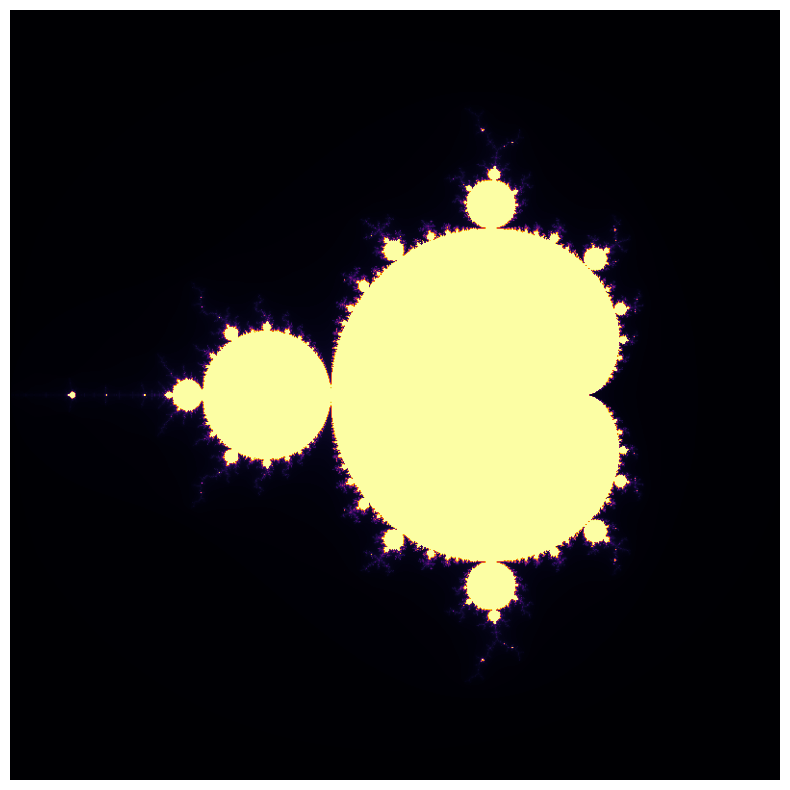

In [720]:
# Function to check if number is in mondelbrot set
def mandel_check(c, max_iter):
    limit = 0
    n = 0
    while abs(limit) <= 2 and n < max_iter:
        limit = limit*limit + c
        n += 1
    if n == max_iter: 
        return max_iter
    else: 
        #Gradient for picture
        return n + 1 - np.log(np.log2(abs(limit)))
# Drawing
width, height = 800, 800
x = np.linspace(-2, 1, width)
y = np.linspace(-1.5, 1.5, height)
mandelbrot_image = np.array([[mandel_check(x[ix] + 1j*y[iy], 300) for ix in range(width)] for iy in range(height)])
print(mandelbrot_image)
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_image, extent=[-2, 1, -1.5, 1.5], cmap='inferno')
plt.axis('off')
plt.show()


In [1375]:
import jax

# List all available JAX devices
devices = jax.devices()
print("Available devices:", devices)

# Check if GPU or TPU is available
gpu_devices = [device for device in devices if 'gpu' in str(device).lower()]
tpu_devices = [device for device in devices if 'tpu' in str(device).lower()]

print("GPU devices:", gpu_devices)
print("TPU devices:", tpu_devices)


Available devices: [CpuDevice(id=0)]
GPU devices: []
TPU devices: []


In [16]:
# Not parallel
def area_mandel(n_sampl, max_iter):
    x_min = -2
    x_max = 1
    y_min = -1.5
    y_max = 1.5
    sampler = 0
    hit = 0
    while sampler < n_sampl:
        # Sample
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        sampler += 1
        c = x + 1j*y
        #check
        cheker = mandel_check(c, max_iter)
        if cheker == max_iter:
            hit +=1
    area = (x_max - x_min)*(y_max - y_min) * (hit/sampler)
    return area


print(area_mandel(10**6, 500))
        
    

1.511631


In [ ]:
total_samples = 10**6
max_iter = 500
num_cores = 9
smaples = [10**6]
iters = [100]
num_simulations = 100
simulation_res = []
result = []
for iter in iters:
    simulation_result = [result_extraction_simple(total_samples, iter, num_cores) for _ in range(num_simulations)]
    print(simulation_result)
    simulation_res.append(simulation_result)
    mean_resul = np.mean(simulation_result)
    std_deviatio = np.std(simulation_result)
    result.append((mean_resul, std_deviatio))

result


In [1389]:
# Here I create samples and check whether they are in mandelbrot set. I use jnp which processes computation on GPU and numexpr for multithreading, 
# numpy for vectorisation and joblib for multiprocessing. Overall 11.5 times faster then area_mandel
def area_mandel_vect_numexpr(n_sampl, max_iter):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    c = ne.evaluate("x + 1j * y")
    cheker = jnp.zeros(c.shape, dtype=complex)
    hit = jnp.zeros(c.shape, dtype=int)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), n_sampl
# Here I extract results and combine them to calculate area
def result_extraction_simple_numexpr(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(area_mandel_vect_numexpr)(samples_per_core, max_iter) for core in range(num_cores)
    )
    hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    samples = jnp.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return area

In [1257]:
area_estimate = result_extraction_simple_numexpr(100000, 1000, 1)
print("Estimated area:", area_estimate)

Estimated area: 1.50471


In [1390]:
execution_time = timeit.timeit(lambda: result_extraction_simple_numexpr(10**6, 1000, 10), number=20)
print(f"Average execution time over 10 runs: {execution_time/20} seconds")

Average execution time over 10 runs: 1.216477664548438 seconds


In [1370]:
execution_time = timeit.timeit(lambda: area_mandel(10**6, 1000), number=2)
print(f"Average execution time over 10 runs: {execution_time/2} seconds")


Average execution time over 10 runs: 14.019558812491596 seconds


In [759]:
# TODO: Change logic of list creation to optimise and use jnp
def stratified_sampling(n_sampl, max_iter, num ):
    x_min, x_max, y_min, y_max = -2, 1, 0, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    np.random.shuffle(y_samples)
    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)
    c = x_samples + 1j * y_samples
    #print(c[0])
    cheker = np.zeros(c.shape, dtype=complex)
    hit = np.zeros(c.shape, dtype=float)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return np.sum(mask == True), n_sampl

def result_extraction_stratifies(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(stratified_sampling)(samples_per_core, max_iter, 8) for core in range(num_cores)
    )
    #print(results)
    hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    #print(hits)
    samples = np.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    #print(samples)
    x_min, x_max, y_min, y_max = -2, 1, 0, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return area*2

In [760]:
res_stratifies = [result_extraction_stratifies(10**6, 1000, 9) for _ in range(100)]
std_stratifies= np.std(res_stratifies)
mean_stratifies = np.mean(res_stratifies)
print(f"Mean is {mean_stratifies}, Sdt is {std_stratifies}")

Mean is 1.510787770787771, Sdt is 0.0024850411874359824


(array([ 3.,  6., 18., 18., 20., 16.,  7.,  5.,  4.,  3.]),
 array([1.50540451, 1.50659791, 1.50779131, 1.50898471, 1.51017811,
        1.51137151, 1.51256491, 1.51375831, 1.51495171, 1.51614512,
        1.51733852]),
 <BarContainer object of 10 artists>)

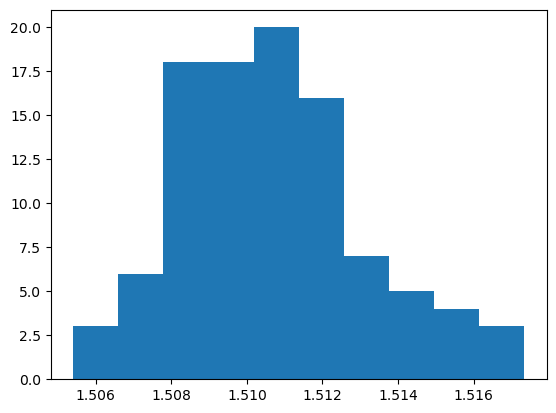

In [769]:
plt.hist(res_stratifies)

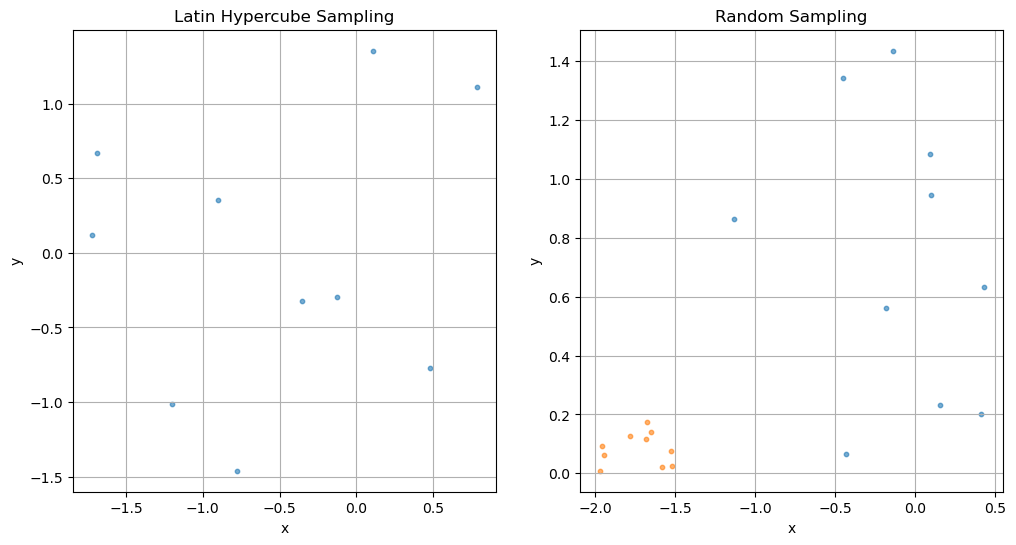

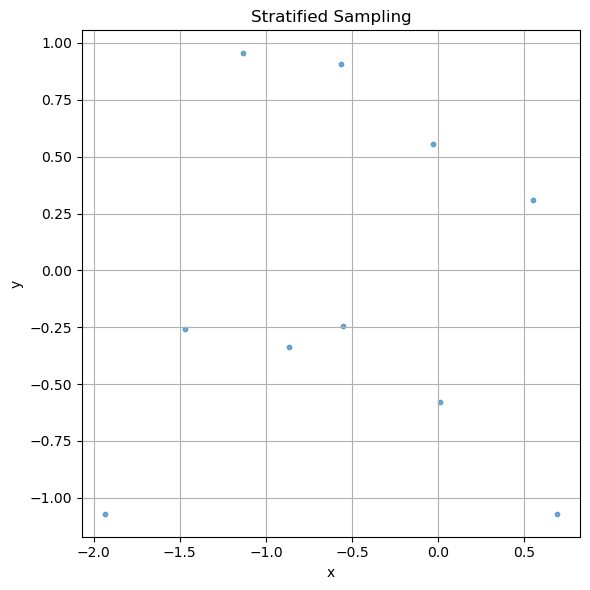

ValueError: x and y must be the same size

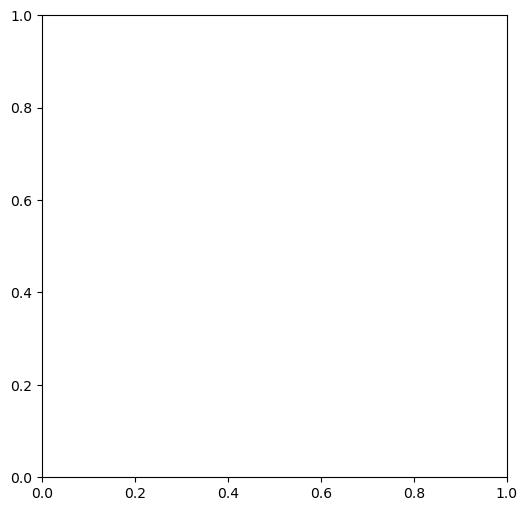

In [804]:

def latin_hypercube_sampling(n_sampl):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / n_sampl
    y_h = y_len / n_sampl
    x_array = np.array([x_min + x_h * a for a in range(n_sampl + 1)])
    y_array = np.array([y_min + y_h * a for a in range(n_sampl + 1)])
    x = np.array([np.random.uniform(x_array[a], x_array[a + 1], 1) for a in range(n_sampl)])
    y = np.array([np.random.uniform(y_array[a], y_array[a + 1], 1) for a in range(n_sampl)])
    np.random.shuffle(y)
    
    return x, y
def random_sampling(n_sampl):
    x_min, x_max, y_min, y_max = -1.5, 0.5, 0, 1.5
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    return x, y
def area_mandel_vect_1(n_sampl):
    x_min, x_max, y_min, y_max = -2, -1.5, 0, 0.2
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    return x, y
def stratified_sampling(n_sampl, num):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    np.random.shuffle(y_samples)
    return np.array(x_samples), np.array(y_samples)
n_sampl = 10

x_lhs, y_lhs = latin_hypercube_sampling(n_sampl)
array1 = np.array([-2, -1.7, -1.4, -1.1, -0.8, -0.5, -0.2, 0.1, 0.4, 0.7, 1])
array2 = np.array([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5])

pairs = np.array(np.meshgrid(array1, array2)).T.reshape(-1, 2) 
xf = pairs[0:,0]
yf = pairs[0,0:]
x_random, y_random = random_sampling(n_sampl)
x_rand, y_rand = area_mandel_vect_1(n_sampl)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_lhs, y_lhs, alpha=0.6, s=10)  
plt.title('Latin Hypercube Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x_random, y_random, alpha=0.6, s=10)  
plt.scatter(x_rand, y_rand, alpha=0.6, s=10)  

plt.title('Random Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

n_sampl = 10
num =5

x_stratified, y_stratified = stratified_sampling(n_sampl, num)

plt.figure(figsize=(6, 6))
plt.scatter(x_stratified, y_stratified, alpha=0.6, s=10)
plt.title('Stratified Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(xf, yf, alpha=0.6, s=10)
plt.title('Stratified Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()

In [483]:
def latin_hypercube_sampling(n, d):
    lower_limits = np.arange(0, n, dtype=float) / n
    upper_limits = np.arange(1, n + 1, dtype=float) / n
    print(upper_limits)
    random_points = np.random.uniform(low=lower_limits, high=upper_limits, size=(d, n)).T
    #np.random.shuffle(random_points[:, 1])
    return random_points

latin_hypercube_sampling(10, 5)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


array([[0.01232664, 0.09222849, 0.01684971, 0.00800631, 0.07634105],
       [0.1903359 , 0.12053517, 0.17603234, 0.17852332, 0.17070732],
       [0.23760611, 0.21207114, 0.28119329, 0.2146504 , 0.23635583],
       [0.31238609, 0.33653902, 0.32446393, 0.35714989, 0.32097271],
       [0.45840502, 0.43122682, 0.4005949 , 0.46062886, 0.4975402 ],
       [0.59970198, 0.50141009, 0.50734678, 0.52333714, 0.50664735],
       [0.62345044, 0.66574191, 0.62240902, 0.63961107, 0.67794866],
       [0.77124911, 0.78950555, 0.74453919, 0.72132328, 0.77835287],
       [0.82124282, 0.80989938, 0.80928971, 0.84818386, 0.87340708],
       [0.9478646 , 0.98100945, 0.95494092, 0.98835478, 0.96416857]])

In [79]:
import timeit
execution_time = timeit.timeit(lambda: result_extraction(10**7, 500, 8), number=4)
print(f"Average execution time over 10 runs: {execution_time/4} seconds")

Average execution time over 10 runs: 8.735422104015015 seconds


In [1360]:
def generate_samples(n_sampl, minmax):
    #print(n_sampl)
    xmin , xmax = minmax
    intervals = np.linspace(xmin, xmax, n_sampl+1)
    #print(intervals)
    f = lambda pair: np.random.uniform(pair[0], pair[1])
    mapflt = lambda f, xs: map(f, zip(xs, xs[1:]))
    points = list(mapflt(f, intervals))
    #print(points)
    return points
# TODO: maybe spreading x, y between two chunks of processors is faster??
def latin_hypercube_parallel(total_samples, dimensions, num_cores):
    samples_per_core = (total_samples) // (num_cores)
    x_strata_per_core = np.linspace(-2, 0.5, (num_cores+1))
    y_strata_per_core = np.linspace(-1.5, 1.5, (num_cores+1))
    #print(x_strata_per_core)
    f = lambda x , y : (x[y], x[y+1])
    results_x = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(x_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_x)
    results_y = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(y_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_y)
    combo_x = np.concatenate(results_x)
    #print(combined_samples_x)
    combo_y = np.concatenate(results_y)
    combo =  np.vstack((combo_x, combo_y))
    #print("combo: ", combo)
    return combo.T

def latin_hypercube_mandelbrot_check(chunk, max_iter):
    cheker = jnp.zeros(chunk.shape, dtype=complex)
    hit = jnp.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples but ? might fuckup if number of cores is even ?
def latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores):
    chunks = jnp.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(latin_hypercube_mandelbrot_check)(chunk, max_iter) for chunk in chunks
    )
    total_hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = jnp.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    np.random.shuffle(y_points)
    return ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max):
    points = latin_hypercube_parallel(total_samples, 2, num_cores)
    #print(points)
    c = transform_points_to_complex(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samples = latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return mandelbrot_area

max_iter = 1000
num_cores = 8
total_samples = 10**6
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5

area = calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max)
print(f"Estimated area of the Mandelbrot set: {area}")


Estimated area of the Mandelbrot set: 1.510927438735962


In [1392]:
max_iter = 5000
num_cores = 10
total_samples = 10**3
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
res_latin_hypercube = [calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max) for _ in range(100)]
std_latin_hypercube= np.std(res_latin_hypercube)
mean_latin_hypercube = np.mean(res_latin_hypercube)
print(f"Mean is {mean_latin_hypercube}, Sdt is {std_latin_hypercube}")

Mean is 1.5079501867294312, Sdt is 0.06832677870988846


In [1361]:
execution_time = timeit.timeit(lambda: calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max), number=5)
print(f"Average execution time over 10 runs: {execution_time/5} seconds")

Average execution time over 10 runs: 1.5586683750152588 seconds
